In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels.api as sm
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [24]:
filename = "uss_survey_responses.csv"
df = pd.read_csv(filename)

In [25]:
# Dataset Inspection
print("Column Headers:", df.columns.tolist())
print(df.head())

Column Headers: ['time_entry', 'Email Address', 'q1', 'q2', 'q3', 'q4_1', 'q4_2', 'q4_3', 'q4_4', 'q5_1', 'q5_2', 'q5_3', 'q5_4', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14_1', 'q14_2', 'q14_3', 'q14_4', 'q14_5', 'q14_6', 'q14_7', 'q14_8', 'q15', 'q16_1', 'q16_2', 'q16_3', 'q16_4', 'q16_5', 'q17_1', 'q17_2', 'q17_3', 'q17_4', 'q17_5', 'q17_6', 'q18_1', 'q18_2', 'q18_3', 'q18_4', 'q18_5', 'q18_6', 'q19_1', 'q19_2', 'q19_3', 'q19_4', 'q19_5', 'q19_6', 'q19_7', 'q19_8', 'q20']
          time_entry               Email Address                     q1  \
0  3/1/2025 21:58:00       tada.maenth@gmail.com         Solo Traveller   
1  3/1/2025 23:33:19        amelia.low@gmail.com  Visiting With Friends   
2  3/3/2025 20:46:45     funwenxin2003@gmail.com  Visiting With Friends   
3  3/3/2025 21:54:53  tianyuan.zhang03@gmail.com  Visiting With Friends   
4  3/3/2025 21:58:00   chia.kwang.yang@gmail.com         Solo Traveller   

                   q2     q3              q4_1          

In [26]:
# Cleaning the dataset

# Remove the first, second and last column
df = df.iloc[:, 2:-1]
df = df.dropna()
print("Column Headers:", df.columns.tolist())
print(df.head())

Column Headers: ['q1', 'q2', 'q3', 'q4_1', 'q4_2', 'q4_3', 'q4_4', 'q5_1', 'q5_2', 'q5_3', 'q5_4', 'q6', 'q7', 'q8', 'q9', 'q10', 'q11', 'q12', 'q13', 'q14_1', 'q14_2', 'q14_3', 'q14_4', 'q14_5', 'q14_6', 'q14_7', 'q14_8', 'q15', 'q16_1', 'q16_2', 'q16_3', 'q16_4', 'q16_5', 'q17_1', 'q17_2', 'q17_3', 'q17_4', 'q17_5', 'q17_6', 'q18_1', 'q18_2', 'q18_3', 'q18_4', 'q18_5', 'q18_6', 'q19_1', 'q19_2', 'q19_3', 'q19_4', 'q19_5', 'q19_6', 'q19_7', 'q19_8']
                      q1                  q2     q3              q4_1  \
0         Solo Traveller  21 To 34 Years Old  Local   5 To 10 Minutes   
1  Visiting With Friends  21 To 34 Years Old  Local  20 To 30 Minutes   
2  Visiting With Friends  21 To 34 Years Old  Local  20 To 30 Minutes   
3  Visiting With Friends  21 To 34 Years Old  Local  10 To 20 Minutes   
4         Solo Traveller  21 To 34 Years Old  Local  20 To 30 Minutes   

               q4_2              q4_3              q4_4  q5_1  q5_2  q5_3  \
0  10 To 20 Minutes   5 To 10

The code below will demonstrate the exploration of potential use of IOT devices by tourists

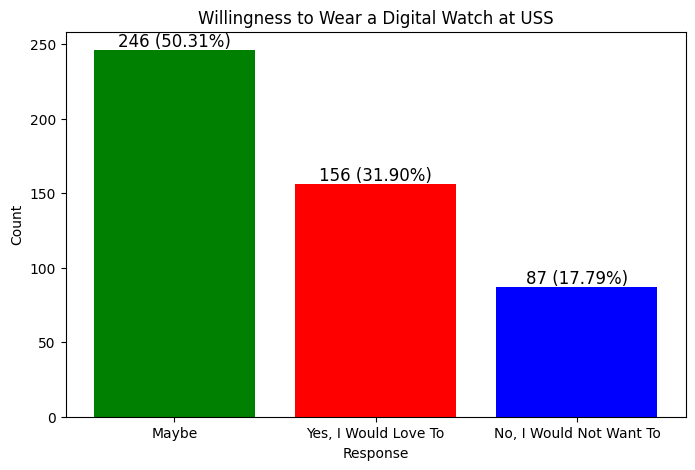

In [8]:
# Plotting a frequency bar chart
question_13_responses = df['q13']
response_counts = question_13_responses.value_counts()
total_responses = response_counts.sum()

# Calculate percentages
response_percentages = (response_counts / total_responses) * 100

# Plotting the results
plt.figure(figsize=(8, 5))
bars = plt.bar(response_counts.index, response_counts.values, color=['green', 'red', 'blue'])

# Adding the text annotations on each bar for count and percentage
for bar, response in zip(bars, response_counts.index):  # Iterate through bars and corresponding responses
    yval = bar.get_height()
    percentage = response_percentages[response]  # Access percentage using the response as the key
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{int(yval)} ({percentage:.2f}%)', va='bottom', ha='center', fontsize=12)

plt.title('Willingness to Wear a Digital Watch at USS')
plt.xlabel('Response')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

The provided data appears to be a breakdown of responses regarding the willingness to wear a digital watch, categorized into three groups:

Yes, I Would Love To: 257 respondents (50.31%)

No, I Would Not Want To: 157 respondents (31.9%)

Maybe: 89 respondents (17.79%)

This data suggests that a majority of respondents (50.31%) are enthusiastic about wearing a digital watch, while a significant portion (31.9%) are not interested. A smaller percentage (17.79%) are undecided or open to the idea.

Conclusion:
The data indicates that more than half of the respondents are positively inclined towards wearing a digital watch, which could imply a favorable market reception for such devices. However, the substantial percentage of respondents who are not interested highlights a segment of the population that may require targeted marketing or additional incentives to consider adoption. The "Maybe" responses represent a potential opportunity to convert undecided individuals into willing users through effective communication and demonstration of the product's benefits. Overall, while there is a strong positive response, understanding and addressing the concerns of the less enthusiastic groups could further enhance market penetration.

Creating a few hypotheses to check whether willingness of IOT adoption correlates with a few variables. Different types of variables require different types of statistical test; for example, categorial variables require chi-square test, ordinal variables require Kruskal-Wallis test and numerical variables require ANOVA. We will begin with categorical variables first, so chi-square tests are used, if the p value is <0.05, we have to reject the null hypothesis which states that there is no difference between the variables

Chi-Square Test Results:
Chi2 Statistic = 5.5540
p-value = 0.8512
Degrees of Freedom = 10

Expected Frequencies Table:


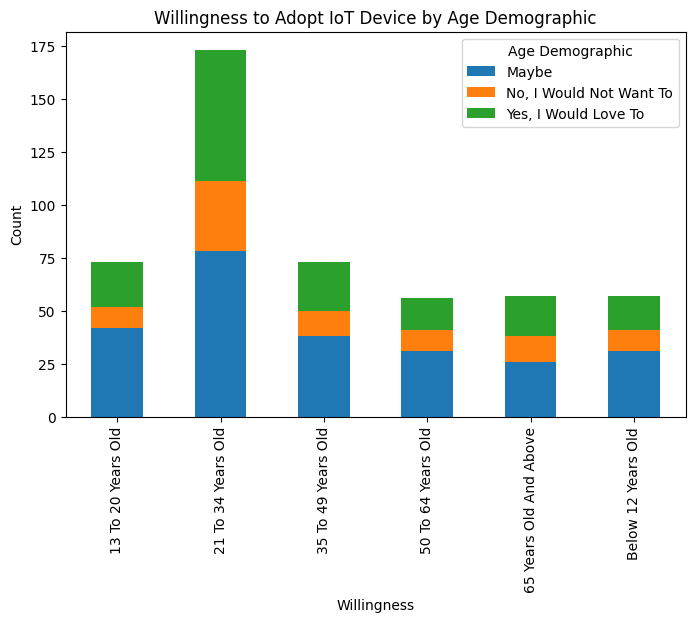

In [9]:
# Hypothesis 1: There is no difference between willingness of IOT Adoption and age demographic
contingency_table = pd.crosstab(df['q2'], df['q13'])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print test results
print("Chi-Square Test Results:")
print(f"Chi2 Statistic = {chi2:.4f}")
print(f"p-value = {p:.4f}")
print(f"Degrees of Freedom = {dof}")
print("\nExpected Frequencies Table:")

# ------------------------
# Visualization: Stacked Bar Chart
# ------------------------
contingency_table.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Willingness to Adopt IoT Device by Age Demographic")
plt.xlabel("Willingness")
plt.ylabel("Count")
plt.legend(title="Age Demographic")
plt.show()


The Chi-Square test results indicate that there is no statistically significant association between age demographic and willingness to adopt IoT devices, as the p-value (0.8512) is much higher than the common significance threshold of 0.05. This means we cannot reject the null hypothesis that age and willingness to adopt IoT devices are independent. What I hypothesized was that perhaps the younger generation will prefer wearing something 'techy', but it seems like all age demographics demonstrated similar proportion of affirnity towards IOT

Chi-Square Test Results:
Chi2 Statistic = 14.1318
p-value = 0.0784
Degrees of Freedom = 8

Expected Frequencies Table:


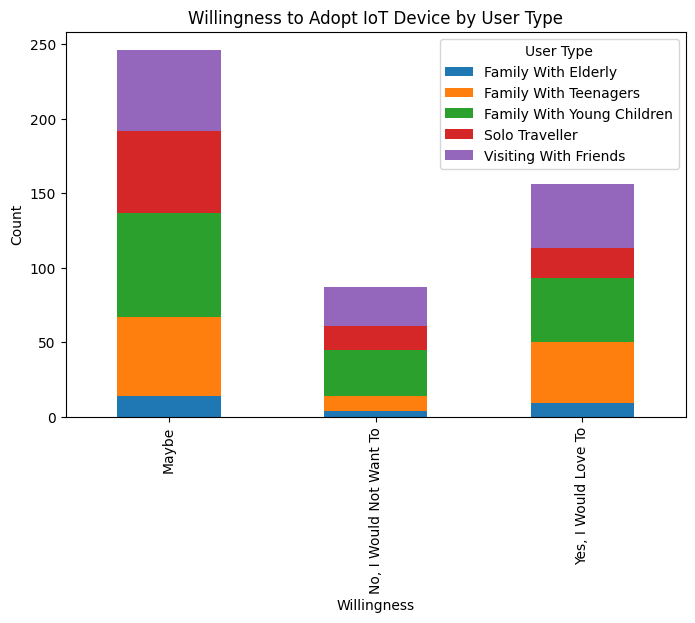

In [10]:
# Hypothesis 2: There is no difference between willingness of IOT Adoption and user type
# Create a contingency table
contingency_table = pd.crosstab(df['q13'], df['q1'])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print test results
print("Chi-Square Test Results:")
print(f"Chi2 Statistic = {chi2:.4f}")
print(f"p-value = {p:.4f}")
print(f"Degrees of Freedom = {dof}")
print("\nExpected Frequencies Table:")

# ------------------------
# Visualization: Stacked Bar Chart
# ------------------------
contingency_table.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Willingness to Adopt IoT Device by User Type")
plt.xlabel("Willingness")
plt.ylabel("Count")
plt.legend(title="User Type")
plt.show()

The Chi-Square test yielded a p-value of 0.0784, which is slightly above the common significance threshold of 0.05. This indicates that there is no statistically significant association between user type and willingness to adopt IoT devices at the 5% significance level. Therefore, we cannot reject the null hypothesis that user type and willingness to adopt IoT devices are independent.

In summary, while there is no strong statistical evidence to support a relationship between user type and willingness to adopt IoT devices, the data does hint at potential trends that could be explored in future research.

Chi-Square Test Results:
Chi2 Statistic = 2.3418
p-value = 0.3101
Degrees of Freedom = 2

Expected Frequencies Table:


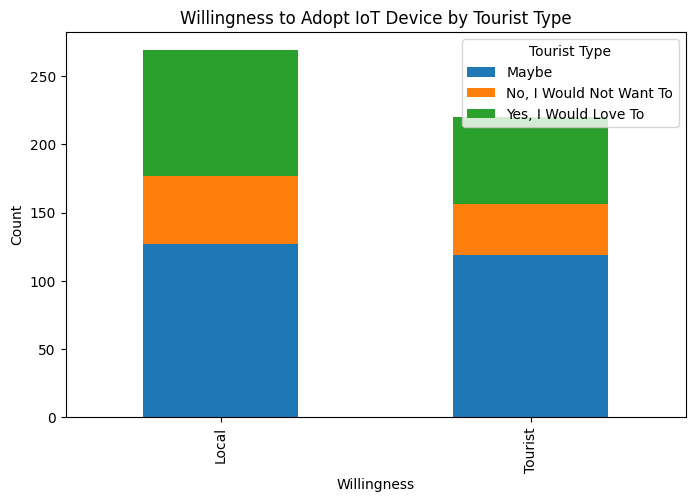

In [11]:
# Hypothesis 3: There is no difference between willingness of IOT Adoption and tourist type
# Create a contingency table
contingency_table = pd.crosstab(df['q3'], df['q13'])

# Perform Chi-Square Test
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

# Print test results
print("Chi-Square Test Results:")
print(f"Chi2 Statistic = {chi2:.4f}")
print(f"p-value = {p:.4f}")
print(f"Degrees of Freedom = {dof}")
print("\nExpected Frequencies Table:")

# ------------------------
# Visualization: Stacked Bar Chart
# ------------------------
contingency_table.plot(kind='bar', stacked=True, figsize=(8, 5))
plt.title("Willingness to Adopt IoT Device by Tourist Type")
plt.xlabel("Willingness")
plt.ylabel("Count")
plt.legend(title="Tourist Type")
plt.show()

The Chi-Square test yielded a p-value of 0.3101, which is slightly above the common significance threshold of 0.05. This indicates that there is no statistically significant association between user type and willingness to adopt IoT devices at the 5% significance level. Therefore, we cannot reject the null hypothesis that user type and willingness to adopt IoT devices are independent.

In summary, while there is no strong statistical evidence to support a relationship between user type and willingness to adopt IoT devices, the data does hint at potential trends that could be explored in future research.

We will perform statistical tests on numerical variables, hence we will use ANOVA and Pearson Coefficient

In [12]:
# Hypothesis 4: There is no difference between willingness of IOT Adoption and waiting times, time spent in USS
# Define variable groups
perceived_wait = ["q4_1", "q4_2", "q4_3", "q4_4"]
unacceptable_wait = ["q5_1", "q5_2", "q5_3", "q5_4"]
hours_spent = ["q9"]
willingness_col = "q13"

# Map willingness to numeric
willingness_map = {
    "Yes, I Would Love To": 2,
    "Maybe": 1,
    "No, I Would Not Want To": 0
}

df[willingness_col] = df[willingness_col].map(willingness_map)

# Time mapping for perceived wait times
time_map = {
    "Less Than 5 Minutes": 2.5,
    "5 To 10 Minutes": 7.5,
    "10 To 20 Minutes": 15,
    "20 To 30 Minutes": 25,
    "30 To 60 Minutes": 45,
    "Over 60 Minutes": 70,
    "I Do Not Visit": None
}

# Helper function to run ANOVA and Pearson correlation
def run_anova_and_corr(columns, label):
    subset = df[columns + [willingness_col]].dropna()

    # Apply time mapping if these are perceived wait time columns
    if all(col in perceived_wait for col in columns):
        for col in columns:
            subset[col] = subset[col].map(time_map)

    # Convert to numeric (for q5 and q9)
    for col in columns:
        subset[col] = pd.to_numeric(subset[col], errors='coerce')

    subset = subset.dropna()

    # ANOVA
    anova = {}
    for col in columns:
        groups = [subset[subset[willingness_col] == val][col] for val in subset[willingness_col].unique()]
        f_stat, p_val = stats.f_oneway(*groups)
        anova[col] = {"F-statistic": f_stat, "p-value": p_val}

    # Correlation
    corr = subset[columns].corrwith(subset[willingness_col])

    print(f"\n=== {label.upper()} ===")
    print("ANOVA Results:")
    for col, res in anova.items():
        print(f"{col}: F = {res['F-statistic']:.4f}, p = {res['p-value']:.4f}")
    print("\nPearson Correlation:")
    print(corr)

# Run analysis for each group
run_anova_and_corr(perceived_wait, "Perceived Wait Times (q4)")
run_anova_and_corr(unacceptable_wait, "Unacceptable Wait Times (q5)")
run_anova_and_corr(hours_spent, "Hours Spent in Park (q9)")



=== PERCEIVED WAIT TIMES (Q4) ===
ANOVA Results:
q4_1: F = 0.5778, p = 0.5617
q4_2: F = 0.2590, p = 0.7720
q4_3: F = 1.5175, p = 0.2209
q4_4: F = 0.6018, p = 0.5484

Pearson Correlation:
q4_1    0.059505
q4_2    0.037414
q4_3   -0.085715
q4_4   -0.060447
dtype: float64

=== UNACCEPTABLE WAIT TIMES (Q5) ===
ANOVA Results:
q5_1: F = 1.0453, p = 0.3524
q5_2: F = 0.0969, p = 0.9077
q5_3: F = 0.1417, p = 0.8679
q5_4: F = 0.6074, p = 0.5452

Pearson Correlation:
q5_1   -0.002097
q5_2    0.001464
q5_3    0.023261
q5_4   -0.008272
dtype: float64

=== HOURS SPENT IN PARK (Q9) ===
ANOVA Results:
q9: F = 0.5032, p = 0.6049

Pearson Correlation:
q9    0.043213
dtype: float64


1. Perceived Wait Times (q4)
ANOVA Results:
All p-values > 0.05 → No statistically significant difference in perceived wait times among different willingness groups.
The highest F-statistic was q4_3 (2.2471, p = 0.1098), which is still not significant.
Pearson Correlation:
q4_1 (+0.156) suggests a very weak positive correlation between perceived wait times for thrill rides and willingness.
q4_3 (-0.161) suggests a very weak negative correlation for performances.
However, none of these are strong relationships.
Conclusion:
People’s perceived wait times do not significantly influence their willingness to adopt an IoT device.

2. Unacceptable Wait Times (q5)
ANOVA Results:
All p-values > 0.05 → No statistically significant differences in unacceptable wait times across willingness groups.
The highest F-statistic was q5_2 (0.4606, p = 0.6316), which is very far from significance.
Pearson Correlation:
All correlations are very close to 0, meaning there is no meaningful relationship.
The highest correlation, q5_2 (-0.0678), is still very weak and negative.
Conclusion:
People’s tolerance for waiting times (unacceptable limits) is NOT related to their willingness to use an IoT device.

3. Hours Spent in the Park (q9)
ANOVA Results:
F = 1.9154, p = 0.1501 → No statistically significant difference in the average hours spent in the park among different willingness groups.
Pearson Correlation:
q9 (+0.134) suggests a weak positive correlation → People who spend more time in the park might be slightly more willing to adopt IoT, but the relationship is weak.
Conclusion:
Spending more hours in the park has a small positive effect on willingness, but it is not a strong or statistically significant factor.

For the final one, we will perform regression analysis through Original Least Square between IOT Adoption and ordinal variables

In [19]:
# Hypothesis 5: There is no difference between willingness of IOT Adoption and satisfaction with queueing systems
# Define relevant columns
willingness_col = "q13"  # Willingness to adopt IoT
question_16_1_col = "q16_1"  # Satisfaction with the queuing system

# Select relevant data and drop missing values
df_subset_16_1 = df[[question_16_1_col, willingness_col]].dropna()

# Convert willingness responses to numeric values
willingness_map = {
    "Yes, I Would Love To": 2,
    "Maybe": 1,
    "No, I Would Not Want To": 0
}
df_subset_16_1[willingness_col] = df_subset_16_1[willingness_col].map(willingness_map)

# Convert satisfaction ratings to numeric (assuming ordinal values like 1-5)
df_subset_16_1[question_16_1_col] = pd.to_numeric(df_subset_16_1[question_16_1_col], errors='coerce')

# Define independent variable (satisfaction with queuing system)
X_16_1 = df_subset_16_1[[question_16_1_col]]

# Define dependent variable (willingness to adopt IoT)
y = df_subset_16_1[willingness_col]

# Add constant term for intercept
X_16_1 = sm.add_constant(X_16_1)

# Fit the regression model
model_16_1 = sm.OLS(y, X_16_1).fit()

# Display regression summary
print("\n=== Regression Results for `q16_1` (Satisfaction with Queuing) vs. Willingness to Adopt IoT (`q13`) ===")
print(model_16_1.summary())


=== Regression Results for `q16_1` (Satisfaction with Queuing) vs. Willingness to Adopt IoT (`q13`) ===
                            OLS Regression Results                            
Dep. Variable:                    q13   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.330
Date:                Sat, 22 Mar 2025   Prob (F-statistic):             0.0122
Time:                        13:43:33   Log-Likelihood:                -509.73
No. Observations:                 489   AIC:                             1023.
Df Residuals:                     487   BIC:                             1032.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

The model is statistically significant (p = 0.012) → Satisfaction with the queuing system does have a measurable but weak impact on willingness to adopt an IoT device.
R² = 0.013 means that only 1.3% of the variation in willingness is explained by queuing satisfaction — indicating that other factors account for the vast majority of variation.
The negative coefficient (-0.0577) suggests a slight decrease in willingness as satisfaction with queuing increases, meaning users who are less satisfied with queuing may be slightly more open to IoT solutions that could improve their experience.

In [23]:
# Hypothesis 5: There is no difference between willingness of IOT Adoption and satisfaction with crowd management
# Define relevant columns
willingness_col = "q13"  # Willingness to adopt IoT
question_17_6_col = "q17_6"  # Satisfaction with crowd management, comfort, staff helpfulness

# Select relevant data and drop missing values
df_subset_17_6 = df[[question_17_6_col, willingness_col]].dropna()

# Convert willingness responses to numeric values
willingness_map = {
    "Yes, I Would Love To": 2,
    "Maybe": 1,
    "No, I Would Not Want To": 0
}
df_subset_17_6[willingness_col] = df_subset_17_6[willingness_col].map(willingness_map)

# Convert satisfaction ratings to numeric (assuming ordinal values like 1-5)
df_subset_17_6[question_17_6_col] = pd.to_numeric(df_subset_17_6[question_17_6_col], errors='coerce')

# Drop any remaining NaN values
df_subset_17_6 = df_subset_17_6.dropna()

# Define independent variable (satisfaction with crowd management)
X_17_6 = df_subset_17_6[[question_17_6_col]]

# Define dependent variable (willingness to adopt IoT)
y = df_subset_17_6[willingness_col]

# Add constant term for intercept
X_17_6 = sm.add_constant(X_17_6)

# Fit the regression model
model_17_6 = sm.OLS(y, X_17_6).fit()

# Display regression summary
print("\n=== Regression Results for `q17_6` (Satisfaction with Crowd Management) vs. Willingness to Adopt IoT (`q13`) ===")
print(model_17_6.summary())


=== Regression Results for `q17_6` (Satisfaction with Crowd Management) vs. Willingness to Adopt IoT (`q13`) ===
                            OLS Regression Results                            
Dep. Variable:                    q13   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.336
Date:                Sat, 22 Mar 2025   Prob (F-statistic):             0.0213
Time:                        13:45:51   Log-Likelihood:                -510.22
No. Observations:                 489   AIC:                             1024.
Df Residuals:                     487   BIC:                             1033.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------

The model is statistically significant (p = 0.021), indicating that satisfaction with crowd management has a measurable but weak relationship with willingness to adopt IoT devices.
The R² = 0.011 means that only 1.1% of the variation in willingness is explained by this factor — suggesting that other variables are much more influential.
The negative coefficient (-0.0514) shows that as satisfaction with crowd management increases, willingness to adopt IoT devices slightly decreases. This implies that individuals who are less satisfied with crowd control may be more open to technological solutions that could improve that experience.



LASSO Logistic Regression was used to identify key predictors of willingness to adopt IoT

In [27]:
# Binarize q13
df["q13_binary"] = df["q13"].map({
    "Yes, I Would Love To": 1,
    "Maybe": 0,
    "No, I Would Not Want To": 0
})

# Drop rows where target is missing
df = df.dropna(subset=["q13_binary"])

# Set up X and y
X = df.drop(columns=["q13", "q13_binary"])
y = df["q13_binary"]

# Identify categorical and numeric columns
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Define preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine transformations
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_cols),
    (categorical_transformer, categorical_cols)
)

print(preprocessor)
# Create LASSO Logistic Regression pipeline
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("lasso", LogisticRegressionCV(
        Cs=10,
        cv=5,
        penalty="l1",
        solver="saga",
        max_iter=5000,
        random_state=42
    ))
])

# Fit the pipeline
pipeline.fit(X, y)

# Extract coefficients and feature names
model = pipeline.named_steps["lasso"]
feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
coefficients = model.coef_[0]

# Combine feature names and coefficients
feature_importance = pd.Series(coefficients, index=feature_names)

# Filter and sort non-zero features
selected_features = feature_importance[feature_importance != 0].sort_values(ascending=False)

# Display top features
print("\n Selected Features with Non-Zero Coefficients:")
print(selected_features)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['q5_1', 'q5_2', 'q5_3', 'q5_4', 'q9', 'q15',
                                  'q16_1', 'q16_2', 'q16_3', 'q16_4', 'q16_5',
                                  'q17_1', 'q17_2', 'q17_3', 'q17_4', 'q17_5',
                                  'q17_6', 'q19_1', 'q19_2', 'q19_3', 'q19_4',
                                  'q19_5', 'q19_6', 'q19_7', 'q19_8']),
                                ('pipeline-2',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['q1', 'q2', 'q3', 

No variables showed significant influence, suggesting that the existing features do not strongly explain willingness in this dataset.

Two datasets regarding wifi connectivity and usage are used as a reference to evaluate if wearable devices as part of IOT network (which uses wifi as as a hub) can be implemented in theme parks.

<ipython-input-20-ae38bb4b093b>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=wifi_survey, x="Quality", palette="Blues")


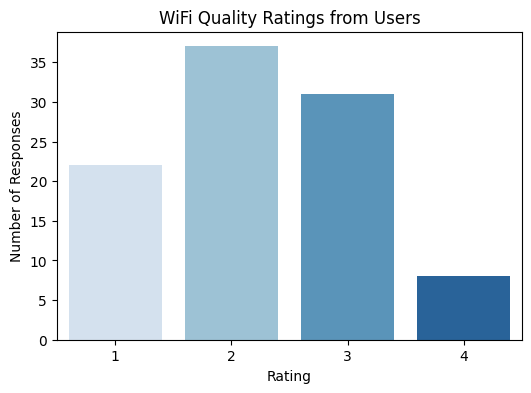

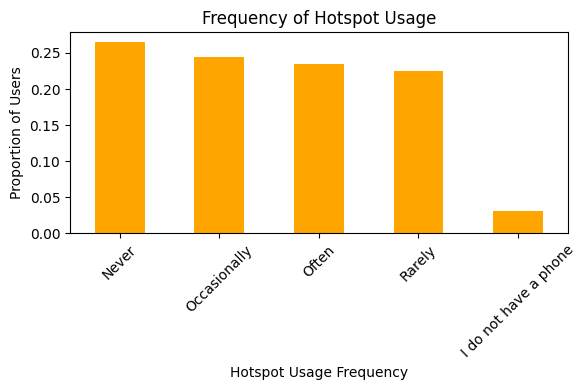

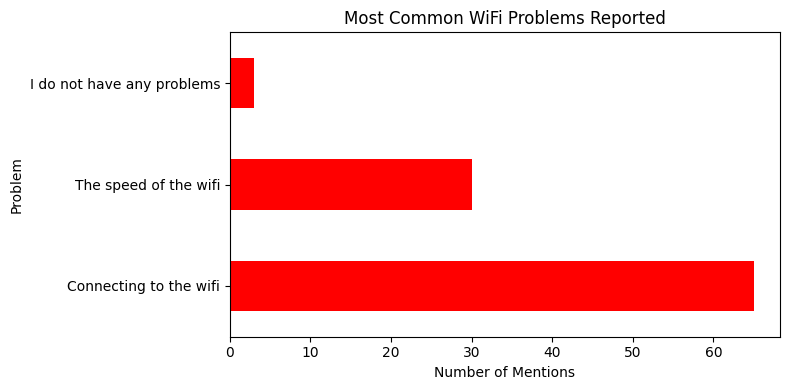

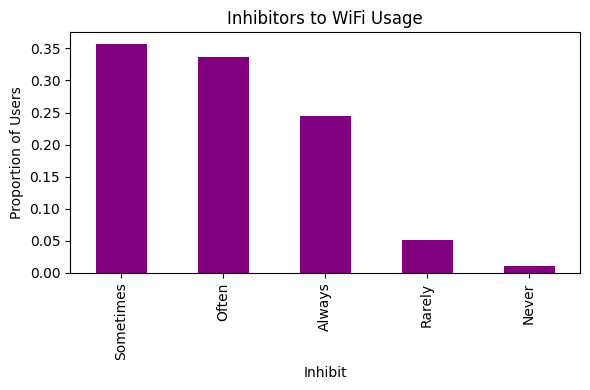

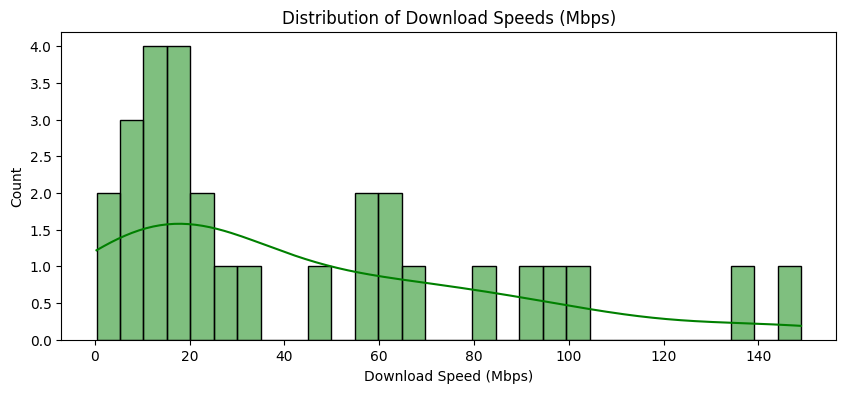

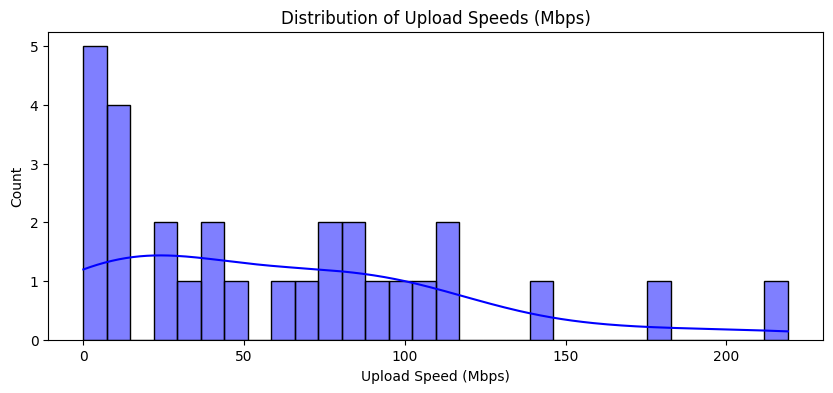

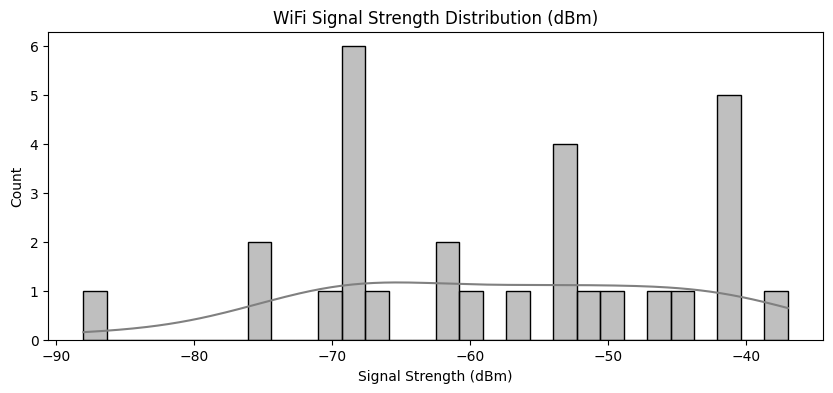


📊 Technical Performance Summary:
       SpeedDownload  SpeedUpload  StrengthStrongest
count      29.000000    29.000000          29.000000
mean       43.995862    61.417241         -57.862069
std        40.649851    56.253433          13.059545
min         0.360000     0.070000         -88.000000
25%        13.060000    12.740000         -69.000000
50%        24.060000    44.910000         -57.000000
75%        64.000000    90.900000         -46.000000
max       149.000000   219.100000         -37.000000


In [20]:
# Load the datasets
wifi_survey = pd.read_csv("WiFiSurvey.csv")
wifi_data = pd.read_csv("WiFiData.csv")

# -----------------------------------
# Part 1: User Feedback from Survey
# -----------------------------------

# Drop NAs
wifi_survey = wifi_survey.dropna(subset=["Quality", "HotspotFrequency", "Problem", "Inhibit", "DataPlan"])

# Summary counts
quality_counts = wifi_survey["Quality"].value_counts().sort_index()
hotspot_freq = wifi_survey["HotspotFrequency"].value_counts(normalize=True)
problem_counts = wifi_survey["Problem"].value_counts()
inhibit_counts = wifi_survey["Inhibit"].value_counts(normalize=True)
data_plan_counts = wifi_survey["DataPlan"].value_counts(normalize=True)

# Plot WiFi Quality Ratings
plt.figure(figsize=(6, 4))
sns.countplot(data=wifi_survey, x="Quality", palette="Blues")
plt.title("WiFi Quality Ratings from Users")
plt.xlabel("Rating")
plt.ylabel("Number of Responses")
plt.show()

# Plot Hotspot Usage Frequency
plt.figure(figsize=(6, 4))
hotspot_freq.plot(kind='bar', color='orange')
plt.title("Frequency of Hotspot Usage")
plt.ylabel("Proportion of Users")
plt.xlabel("Hotspot Usage Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Common Problems
plt.figure(figsize=(8, 4))
problem_counts.plot(kind='barh', color='red')
plt.title("Most Common WiFi Problems Reported")
plt.xlabel("Number of Mentions")
plt.tight_layout()
plt.show()

# Plot Inhibitors
plt.figure(figsize=(6, 4))
inhibit_counts.plot(kind='bar', color='purple')
plt.title("Inhibitors to WiFi Usage")
plt.ylabel("Proportion of Users")
plt.tight_layout()
plt.show()

# -----------------------------------
# Part 2: Technical WiFi Performance
# -----------------------------------

# Clean and describe performance data
wifi_data_clean = wifi_data.dropna(subset=["SpeedDownload", "SpeedUpload", "StrengthStrongest"])
speed_stats = wifi_data_clean[["SpeedDownload", "SpeedUpload", "StrengthStrongest"]].describe()

# Plot Download Speeds
plt.figure(figsize=(10, 4))
sns.histplot(wifi_data_clean["SpeedDownload"], kde=True, bins=30, color="green")
plt.title("Distribution of Download Speeds (Mbps)")
plt.xlabel("Download Speed (Mbps)")
plt.show()

# Plot Upload Speeds
plt.figure(figsize=(10, 4))
sns.histplot(wifi_data_clean["SpeedUpload"], kde=True, bins=30, color="blue")
plt.title("Distribution of Upload Speeds (Mbps)")
plt.xlabel("Upload Speed (Mbps)")
plt.show()

# Plot Signal Strength
plt.figure(figsize=(10, 4))
sns.histplot(wifi_data_clean["StrengthStrongest"], kde=True, bins=30, color="gray")
plt.title("WiFi Signal Strength Distribution (dBm)")
plt.xlabel("Signal Strength (dBm)")
plt.show()

# Print summary stats for speed and signal strength
print("\n📊 Technical Performance Summary:")
print(speed_stats)

Based on the analysis of both user survey feedback and technical WiFi performance data, the implementation of IoT-enabled wearables in the theme park setting is technically feasible but comes with operational caveats. The average download and upload speeds (~44 Mbps and ~61 Mbps respectively) far exceed the minimal bandwidth requirements of basic IoT devices, which typically transmit small packets of data well below 1 Mbps. Additionally, the average signal strength of -58 dBm falls within the acceptable range for reliable IoT communication, although weaker signals (as low as -88 dBm) were observed in certain areas, suggesting the need for targeted coverage improvements. User feedback, however, paints a more cautious picture—many report issues such as slow connections, signal drops, and difficulties connecting to the network. While these concerns do not negate the technical capability of the system to support IoT, they highlight the importance of ensuring consistent coverage, minimizing authentication friction, and boosting user trust in the system. Overall, with strategic enhancements to network stability and user experience, adopting IoT wearables using the current WiFi infrastructure is a viable and scalable option for improving theme park operations.

The dataset

In [13]:
df = pd.read_csv("HomeC.csv")
df.columns
df.head()

<ipython-input-13-4fc990a71a1a>:1: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("HomeC.csv")


,time,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],...,visibility,summary,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
0,1451624400,0.932833,0.003483,0.932833,0.000033,0.020700,0.061917,0.442633,0.124150,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
1,1451624401,0.934333,0.003467,0.934333,0.000000,0.020717,0.063817,0.444067,0.124000,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
2,1451624402,0.931817,0.003467,0.931817,0.000017,0.020700,0.062317,0.446067,0.123533,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
3,1451624403,1.022050,0.003483,1.022050,0.000017,0.106900,0.068517,0.446583,0.123133,0.006983,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0
4,1451624404,1.139400,0.003467,1.139400,0.000133,0.236933,0.063983,0.446533,0.122850,0.006850,...,10.0,Clear,29.26,1016.91,9.18,cloudCover,282.0,0.0,24.4,0.0


In [14]:


# Clean column names
df.columns = [col[:-5].replace(' ', '_') if 'kW' in col else col for col in df.columns]

# Drop rows with NaN
df = df.dropna()

# Drop unnecessary columns
df.drop(['House_overall', 'Solar'], axis=1, inplace=True)
df = df[df['cloudCover'] != 'cloudCover']
df["cloudCover"] = pd.to_numeric(df["cloudCover"])

# Merge kitchen and furnace components
df['kitchen'] = df['Kitchen_12'] + df['Kitchen_14'] + df['Kitchen_38']
df['Furnace'] = df['Furnace_1'] + df['Furnace_2']

# Drop redundant or unused columns safely
cols_to_drop = ['Furnace_1', 'Furnace_2', 'Kitchen_12', 'Kitchen_14', 'Kitchen_38']
df.drop(columns=cols_to_drop, inplace=True, errors='ignore')  # safely skip missing ones

# Convert time column to datetime index
start_time = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(int(df['time'].iloc[0])))
time_index = pd.date_range(start=start_time, periods=len(df), freq='min')
df['datetime'] = pd.to_datetime(time_index)
df.set_index('datetime', inplace=True)
df.drop(['time'], axis=1, inplace=True)

# Remove rare summary/icon categories
def remove_less_percent(col, percent):
    keep_vals = [val for val, freq in df[col].value_counts(normalize=True).items() if freq >= percent]
    return df[df[col].isin(keep_vals)]

df = remove_less_percent('summary', 0.05)
df = remove_less_percent('icon', 0.05)


<ipython-input-14-1d216351590d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['House_overall', 'Solar'], axis=1, inplace=True)


In [15]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Home_office', 'Fridge', 'Wine_cellar',
       'Garage_door', 'Barn', 'Well', 'Microwave', 'Living_room',
       'temperature', 'icon', 'humidity', 'visibility', 'summary',
       'apparentTemperature', 'pressure', 'windSpeed', 'cloudCover',
       'windBearing', 'precipIntensity', 'dewPoint', 'precipProbability',
       'kitchen', 'Furnace'],
      dtype='object')

In [16]:
# Let's remove rows with values that appear less than a certain percentage %

def remove_less_percent(col, percent):
    keys_to_conserve = [key for key,value in df[col].value_counts(normalize=True).items() if value>=percent]
    return df[df[col].isin(keys_to_conserve)]

print(len(df))
df = remove_less_percent('summary', 0.05)
print(len(df))
df = remove_less_percent('icon', 0.05)
print(len(df))

df.head()

466308
466308
466308


,use,gen,Dishwasher,Home_office,Fridge,Wine_cellar,Garage_door,Barn,Well,Microwave,...,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability,kitchen,Furnace
datetime,,,,,,,,,,,,,,,,,,,,,
2016-01-01 05:58:58,0.631600,0.003467,0.000033,0.043400,0.082500,0.009083,0.012983,0.031767,0.001033,0.004083,...,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000567,0.222783
2016-01-01 05:59:58,1.070017,0.003500,0.000233,0.043583,0.170883,0.008883,0.012500,0.031700,0.001083,0.004083,...,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000583,0.560533
2016-01-01 06:00:58,1.016250,0.003467,0.000217,0.043533,0.149550,0.008900,0.012567,0.031733,0.001017,0.004083,...,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000633,0.529450
2016-01-01 06:01:58,0.820667,0.003467,0.000217,0.043583,0.010500,0.007733,0.012617,0.031767,0.001017,0.004100,...,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.001083,0.509867
2016-01-01 06:02:58,0.539167,0.003517,0.000033,0.043367,0.007617,0.007083,0.013133,0.031800,0.001017,0.004083,...,28.87,1015.98,8.2,0.75,281.0,0.0,23.39,0.0,0.000733,0.216417


In [12]:
df.columns

Index(['use', 'gen', 'Dishwasher', 'Furnace_1', 'Furnace_2', 'Home_office',
       'Fridge', 'Wine_cellar', 'Garage_door', 'Kitchen_12', 'Kitchen_14',
       'Kitchen_38', 'Barn', 'Well', 'Microwave', 'Living_room', 'temperature',
       'icon', 'humidity', 'visibility', 'summary', 'apparentTemperature',
       'pressure', 'windSpeed', 'cloudCover', 'windBearing', 'precipIntensity',
       'dewPoint', 'precipProbability', 'kitchen', 'Furnace'],
      dtype='object')

In [31]:
# -----------------------------------------------
# 2. FEATURE ENGINEERING
# -----------------------------------------------
# Convert 'summary' and 'icon' to numeric if they are still object type
for col in ['summary', 'icon']:
    if df[col].dtype == 'object':
        df[col] = pd.factorize(df[col])[0]  # Convert to numeric representation

df = df.resample('5min').mean().dropna()
df = df.iloc[:10000] # The dataset has more than 100000 records, have to downsize to the latest 10000

target = 'use'
X = df.drop(columns=[target]).select_dtypes(include=[np.number])
y = df[target]

# Add time-based features
X['hour'] = df.index.hour
X['dayofweek'] = df.index.dayofweek

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [38]:
df.shape
print(df.head())

                          use       gen  Dishwasher  Home_office    Fridge  \
datetime                                                                     
2016-01-01 05:55:00  0.850808  0.003483    0.000133     0.043492  0.126692   
2016-01-01 06:00:00  0.780330  0.003483    0.000110     0.043340  0.035740   
2016-01-01 06:05:00  0.884200  0.003477    0.000047     0.043047  0.005373   
2016-01-01 06:10:00  0.576747  0.003457    0.000117     0.043513  0.005053   
2016-01-01 06:15:00  0.647967  0.003453    0.000033     0.043187  0.006143   

                     Wine_cellar  Garage_door      Barn      Well  Microwave  \
datetime                                                                       
2016-01-01 05:55:00     0.008983     0.012742  0.031733  0.001058   0.004083   
2016-01-01 06:00:00     0.007670     0.013050  0.031763  0.001027   0.004090   
2016-01-01 06:05:00     0.007227     0.013390  0.062547  0.001073   0.004100   
2016-01-01 06:10:00     0.006933     0.012890  0.0320

In [36]:
# -----------------------------------------------
# 3. RANDOM FOREST WITH TIME SERIES CV
# -----------------------------------------------
tscv = TimeSeriesSplit(n_splits=5)
mae_list, rmse_list = [], []

for train_idx, test_idx in tscv.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_list.append(mean_absolute_error(y_test, y_pred))
    rmse_list.append(mean_squared_error(y_test, y_pred))

print("\n📊 Random Forest Results:")
print(f"Average MAE: {np.mean(mae_list):.4f}")
print(f"Average RMSE: {np.mean(rmse_list):.4f}")


📊 Random Forest Results:
Average MAE: 0.1552
Average RMSE: 0.0905


Interpretation of Results:
MAE (Mean Absolute Error): 0.1552
On average, your model's predictions are off by ~0.16 kW.
RMSE (Root Mean Squared Error): 0.0905
This is a bit more sensitive to larger errors.
A lower RMSE means consistent, accurate predictions overall.

Therefore, it is suitable to be used for predictive model in IOT.

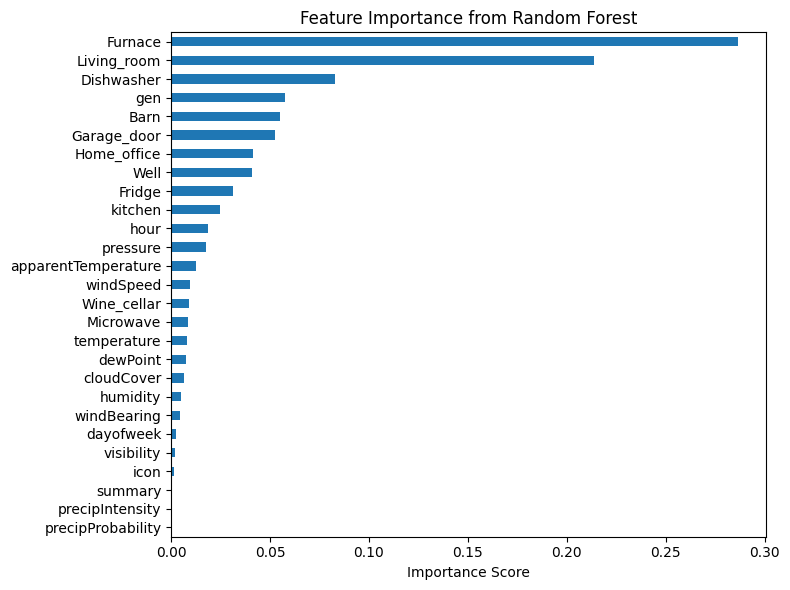

In [37]:
# -----------------------------------------------
# 4. FEATURE IMPORTANCE (AFTER TRAINING ON FULL DATA)
# -----------------------------------------------
model_final = RandomForestRegressor(n_estimators=100, random_state=42)
model_final.fit(X_scaled, y)

# Feature importance
importances = model_final.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
feat_imp.plot(kind='barh')
plt.title("Feature Importance from Random Forest")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

Key Takeaways:
Top Predictors:

Furnace and Living_room are the dominant features, contributing most to overall power usage.
Dishwasher also plays a strong role — likely due to its high-consumption spikes.
Mid-Level Predictors:

Garage_door, Barn, Fridge, Kitchen, Home_office — moderate contributors.
These likely reflect smaller appliances or less consistent usage patterns.

Environmental Variables (e.g. temperature, cloudCover, humidity):

Very low importance here — suggests weather has little direct impact on this household’s energy consumption.